# 🔹UFC Fight Predictor Feature Engineering

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 1. Import Libraries and Setup Environment

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the project root
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Import from /src
sys.path.append(os.path.join(project_root, 'src'))
from helpers import *
from io_model import *
from data import UFCData

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 2. Load Data

In [2]:
# Define the path to the CSV file
file_path = os.path.join(project_root, 'data', 'processed', 'ufc_etl.csv')

# Load the CSV into a DataFrame
try:
    ufc_df = pd.read_csv(file_path)
    print_header(f"Data loaded succesfully", color='bright_green')
except Exception as e:
    print_header(f"Error loading data: {e}", color='bright_red')

╔═══════════════════════════╗
║  Data loaded succesfully  ║
╚═══════════════════════════╝


### Initial Drop for Modeling

In [3]:
ufc_df = ufc_df.drop(['RedFighter','BlueFighter','RedExpectedValue', 'Finish',
                      'BlueExpectedValue','Date','Location','Country', 'BetterRank'],axis=1)

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 3. Initialize UFCData object

In [4]:
ufc_data = UFCData(ufc_df)
ufc_data

📊 UFC Dataset Summary
----------------------------------------
🧪 Total samples      : 6057
🧪 Train/Test split  : 4845 / 1212
🧪 Total features     : 60

🔢 Numerical features : 54
🔠 Categorical features: 6
    - Binary          : 3
    - Multiclass      : 3

🏷 Label distribution (raw):
   - Class 0: 3515 (58.0%)
   - Class 1: 2542 (42.0%)

✅ No missing values detected

📈 Feature summary statistics (train set):
                                mean      std       min       max
RedOdds                     -117.473  281.360 -2100.000   775.000
BlueOdds                      61.305  255.318 -1200.000  1300.000
NumberOfRounds                 3.192    0.587     3.000     5.000
BlueCurrentLoseStreak          0.497    0.792     0.000     6.000
BlueCurrentWinStreak           0.984    1.421     0.000    12.000
BlueDraws                      0.022    0.150     0.000     2.000
BlueLongestWinStreak           1.944    1.916     0.000    17.000
BlueLosses                     1.878    2.180     0.000    1

## 4. Feature Engineering

### Categorical Data

#### Stance
- **Orthodox Stance:** A fighter in orthodox stance leads with their left foot and left hand, making it the natural stance for right-handed individuals. 
- **Southpaw Stance:** A fighter in southpaw stance leads with their right foot and right hand, making it the natural stance for left-handed individuals. 
- **Switch:** When a fighter switches from an orthodox to a southpaw stance or vice versa, it can disrupt their opponent's rhythm, causing them to miss or react incorrectly to strikes.

This features are codified in Fight Stance Column via Closed and Open Stances Matchups

###  Weight Class

In [5]:
ufc_df['WeightClass'].unique()

array(['Welterweight', 'Featherweight', 'Flyweight', 'Light Heavyweight',
       'Bantamweight', 'Lightweight', "Women's Flyweight",
       "Women's Strawweight", 'Heavyweight', 'Catch Weight',
       'Middleweight', "Women's Bantamweight", "Women's Featherweight"],
      dtype=object)

In [6]:
ufc_df[ufc_df['WeightClass'] == 'Catch Weight']

,RedOdds,BlueOdds,TitleBout,WeightClass,Gender,NumberOfRounds,BlueCurrentLoseStreak,BlueCurrentWinStreak,BlueDraws,BlueLongestWinStreak,...,KODif,SubDif,HeightDif,ReachDif,AgeDif,SigStrDif,AvgSubAttDif,AvgTDDif,FightStance,label
22,-112.0,-108.0,False,Catch Weight,MALE,3,0,1,0,2,...,0,-3,-2.54,-7.62,-3,0.2300,-0.7000,-1.6500,Open Stance,1
43,-1000.0,650.0,False,Catch Weight,MALE,3,2,0,0,1,...,-2,0,2.54,-5.08,-3,0.8700,0.0000,0.0000,Closed Stance,0
68,215.0,-265.0,False,Catch Weight,MALE,3,0,2,0,2,...,-1,-1,7.62,20.32,-5,-1.2800,-0.4000,1.5200,Open Stance,0
195,240.0,-298.0,False,Catch Weight,MALE,3,0,3,0,3,...,-2,-1,10.16,2.54,-3,0.5400,2.6000,-0.4900,Closed Stance,1
419,-115.0,-105.0,False,Catch Weight,MALE,3,0,2,0,3,...,-1,3,7.62,5.08,5,-1.5400,0.7000,0.1800,Open Stance,0
424,-160.0,195.0,False,Catch Weight,MALE,3,0,1,0,1,...,-1,1,5.08,2.54,6,1.6800,2.1000,1.5100,Closed Stance,0
476,300.0,-380.0,False,Catch Weight,MALE,3,0,0,0,0,...,0,0,0.00,-5.08,-13,2.6800,0.0000,0.0000,Closed Stance,1
512,-380.0,300.0,False,Catch Weight,MALE,5,0,1,0,4,...,1,0,-7.62,2.54,5,0.5100,0.0000,-0.3000,Open Stance,0
608,116.0,-136.0,False,Catch Weight,MALE,3,0,1,0,2,...,0,1,0.00,-5.08,0,-3.2900,1.0000,2.7500,Closed Stance,1
625,-156.0,130.0,False,Catch Weight,MALE,3,1,0,0,2,...,1,1,2.54,10.16,4,-0.8100,0.2000,-1.6700,Closed Stance,1


In [7]:
ufc_df = ufc_df[ufc_df['WeightClass'] != 'Catch Weight']

In [8]:
ufc_df['WeightClass'].unique()

array(['Welterweight', 'Featherweight', 'Flyweight', 'Light Heavyweight',
       'Bantamweight', 'Lightweight', "Women's Flyweight",
       "Women's Strawweight", 'Heavyweight', 'Middleweight',
       "Women's Bantamweight", "Women's Featherweight"], dtype=object)

In [9]:
# Diccionario de mapeo de WeightClass → WeightGroup
weight_class_map = {
    'Flyweight': 'Light',
    'Bantamweight': 'Light',
    'Featherweight': 'Light',
    'Lightweight': 'Light',
    'Welterweight': 'Medium',
    'Middleweight': 'Medium',
    'Light Heavyweight': 'Heavy',
    'Heavyweight': 'Heavy',
    "Women's Flyweight": 'Women',
    "Women's Strawweight": 'Women',
    "Women's Bantamweight": 'Women',
    "Women's Featherweight": 'Women',
}
# Crear nueva columna con el grupo
ufc_df['WeightGroup'] = ufc_df['WeightClass'].map(weight_class_map)

In [10]:
ufc_df['WeightGroup']

0       Medium
1        Light
2        Light
3        Heavy
4        Light
         ...  
6052     Light
6053    Medium
6054     Heavy
6055    Medium
6056     Heavy
Name: WeightGroup, Length: 6001, dtype: object

In [11]:
ufc_df['WeightClass']

0            Welterweight
1           Featherweight
2               Flyweight
3       Light Heavyweight
4            Bantamweight
              ...        
6052          Lightweight
6053         Welterweight
6054          Heavyweight
6055         Welterweight
6056    Light Heavyweight
Name: WeightClass, Length: 6001, dtype: object

In [12]:
ufc_df=ufc_df.drop(['WeightClass'], axis=1)

### Feature Construction

In [13]:
# Finish Rate (Red & Blue):
RedFinishRate = (ufc_df['RedWinsByKO'] + ufc_df['RedWinsBySubmission'] + ufc_df['RedWinsByTKODoctorStoppage']) / ufc_df['RedWins'].replace(0, 1)
BlueFinishRate = (ufc_df['BlueWinsByKO'] + ufc_df['BlueWinsBySubmission'] + ufc_df['BlueWinsByTKODoctorStoppage']) / ufc_df['BlueWins'].replace(0, 1)
ufc_df['FinishRateDif'] = BlueFinishRate - RedFinishRate

In [14]:
#Win Ratio (Red & Blue)
RedWinRatio = ufc_df['RedWins'] / (ufc_df['RedWins'] + ufc_df['RedLosses']).replace(0, 1)
BlueWinRatio = ufc_df['BlueWins'] / (ufc_df['BlueWins'] + ufc_df['BlueLosses']).replace(0, 1)
ufc_df['WinRatioDif']= BlueWinRatio - RedWinRatio 

In [15]:
# Experience per Age
RedExpPerAge = ufc_df['RedTotalRoundsFought'] / ufc_df['RedAge']
BlueExpPerAge = ufc_df['BlueTotalRoundsFought'] / ufc_df['BlueAge']
ufc_df['ExpPerAgeDif'] = BlueExpPerAge - RedExpPerAge

In [16]:
# Reach Advantage Ratio
ufc_df['ReachAdvantageRatioDif'] = ufc_df['BlueReachCms'] / ufc_df['RedReachCms']

In [17]:
# Height/Reach Ratio
RedHeightReachRatio = ufc_df['RedHeightCms'] / ufc_df['RedReachCms']
BlueHeightReachRatio = ufc_df['BlueHeightCms'] / ufc_df['BlueReachCms']
ufc_df['HeightReachRatioDif']= BlueHeightReachRatio - RedHeightReachRatio

In [18]:
# Win By Decision
BlueWinsByDecision = ufc_df[['BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous']].sum(axis=1)
RedWinsByDecision = ufc_df[['RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous']].sum(axis=1)
ufc_df['WinsByDecisionDif']=BlueWinsByDecision - RedWinsByDecision

# Decision Rate
BlueDecisionRate = BlueWinsByDecision / ufc_df['BlueWins'].replace(0, 1)  # Evitar división por cero
RedDecisionRate = RedWinsByDecision  / ufc_df['RedWins'].replace(0, 1)  # Evitar división por cero
ufc_df['DecisionRateDif']= BlueDecisionRate - RedDecisionRate

In [19]:
# Odds Dif
ufc_df['OddsDif'] = ufc_df['BlueOdds'] - ufc_df['RedOdds']

### Not good

In [20]:
# # AvgSigStrLandedDif
# ufc_df['AvgSigStrLandedDif'] = ufc_df['BlueAvgSigStrLanded'] - ufc_df['RedAvgSigStrLanded']

In [21]:
# # AvgSigStrPctDif
# ufc_df['AvgSigStrPctDif'] = ufc_df['BlueAvgSigStrPct'] - ufc_df['RedAvgSigStrPct']

In [22]:
# # AvgSubAttDif
# ufc_df['AvgSubAttDif'] = ufc_df['BlueAvgSubAtt'] - ufc_df['RedAvgSubAtt']

In [23]:
# # AvgTDLandedDif
# ufc_df['AvgTDLandedDif'] = ufc_df['BlueAvgTDLanded'] - ufc_df['RedAvgTDLanded']

In [24]:
# # AvgTDPctDif
# ufc_df['AvgTDPctDif'] = ufc_df['BlueAvgTDPct'] - ufc_df['RedAvgTDPct']

## 5. Update UFCData object

In [25]:
ufc_data = UFCData(ufc_df)
ufc_data

📊 UFC Dataset Summary
----------------------------------------
🧪 Total samples      : 6001
🧪 Train/Test split  : 4800 / 1201
🧪 Total features     : 68

🔢 Numerical features : 62
🔠 Categorical features: 6
    - Binary          : 3
    - Multiclass      : 3

🏷 Label distribution (raw):
   - Class 0: 3484 (58.1%)
   - Class 1: 2517 (41.9%)

✅ No missing values detected

📈 Feature summary statistics (train set):
                                mean      std       min       max
RedOdds                     -117.620  276.878 -2100.000   775.000
BlueOdds                      62.135  252.956 -1200.000  1300.000
NumberOfRounds                 3.195    0.591     3.000     5.000
BlueCurrentLoseStreak          0.505    0.794     0.000     5.000
BlueCurrentWinStreak           0.970    1.430     0.000    12.000
BlueDraws                      0.021    0.150     0.000     2.000
BlueLongestWinStreak           1.954    1.961     0.000    17.000
BlueLosses                     1.882    2.172     0.000    1

## 6. Feature Selection

Given the following:
-  LoseStreakDif: BlueCurrentLoseStreak - RedCurrentLoseStreak
-  WinStreakDif: BlueCurrentWinStreak - RedCurrentWinStreak
-  LongestWinStreakDif: BlueLongestWinStreak - 'RedLongestWinStreak
-  WinDif: BlueWins - RedWins
-  LossDif: BlueLosses - RedLosses
-  WinRatioDif = BlueWinRatio - RedWinRatio 
-  TotalTitleBoutDif: BlueTotalTitleBouts - RedTotalTitleBouts
-  KODif: BlueWinsByKO - RedWinsByKO
-  SubDif: BlueWinsBySubmission - RedWinsBySubmission
-  HeightDif: BlueHeightCms - RedHeightCms
-  ReachDif: BlueReachCms - RedReachCms
-  AgeDif: BlueAge - RedAge
-  Odds Dif: BlueOdds - RedOdds
-  FightStance: Defined using BlueStance and RedStance
  
We drop redundant columns.

In [26]:
ufc_df=ufc_df.drop(['BlueCurrentLoseStreak', 'RedCurrentLoseStreak','BlueCurrentWinStreak', 'WinDif', 'LossDif',
                      'RedCurrentWinStreak','BlueLongestWinStreak', 'RedLongestWinStreak', 'BlueWins',
                      'RedWins','BlueLosses','RedLosses', 'BlueTotalRoundsFought','RedTotalRoundsFought',
                      'BlueTotalTitleBouts', 'RedTotalTitleBouts', 'BlueWinsByKO', 'RedWinsByKO', 'BlueWinsBySubmission',
                      'RedWinsBySubmission','BlueHeightCms','RedHeightCms','BlueReachCms','RedReachCms',
                      'BlueAge', 'RedAge', 'BlueOdds','RedOdds', 'BlueStance', 'RedStance'], axis=1)

También aquellas relacionadas con los features construidos:
- DecisionRateDif
- FinishRateDif


In [27]:
ufc_df=ufc_df.drop(['WinsByDecisionDif', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous',
       'BlueWinsByTKODoctorStoppage', 'RedWinsByDecisionMajority',
       'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous',
       'RedWinsByTKODoctorStoppage','BlueWinsByDecisionMajority'], axis=1)

### Low Variance columns
- BlueDraws
- RedDraws
- BlueWeightLbs
- RedWeightLbs

In [28]:
ufc_df = ufc_df.drop(['BlueDraws','RedDraws','BlueWeightLbs','RedWeightLbs'], axis=1)

## 7. Update UFCData object

In [29]:
ufc_data = UFCData(ufc_df)
ufc_data

📊 UFC Dataset Summary
----------------------------------------
🧪 Total samples      : 6001
🧪 Train/Test split  : 4800 / 1201
🧪 Total features     : 25

🔢 Numerical features : 21
🔠 Categorical features: 4
    - Binary          : 3
    - Multiclass      : 1

🏷 Label distribution (raw):
   - Class 0: 3484 (58.1%)
   - Class 1: 2517 (41.9%)

✅ No missing values detected

📈 Feature summary statistics (train set):
                           mean      std       min       max
NumberOfRounds            3.195    0.591     3.000     5.000
LoseStreakDif             0.059    1.012    -6.000     6.000
WinStreakDif             -0.162    1.921   -18.000    10.000
LongestWinStreakDif      -0.772    2.053   -12.000    14.000
TotalRoundDif            -5.693   18.286  -448.000    87.000
TotalTitleBoutDif        -0.313    1.709   -16.000    15.000
KODif                    -0.536    2.181   -21.000    14.000
SubDif                   -0.334    1.877   -15.000    10.000
HeightDif                -0.066    6.84

## 8. Check Correlation Matrix

In [30]:
status = False
ufc_data.compute_corr(processed = status)
ufc_data.top_corr(processed = status)

,Feature 1,Feature 2,Correlation
85,TotalRoundDif,ExpPerAgeDif,0.981193
151,ReachDif,ReachAdvantageRatioDif,0.888696
204,ReachAdvantageRatioDif,HeightReachRatioDif,0.643900
132,HeightDif,ReachDif,0.627817
140,HeightDif,ReachAdvantageRatioDif,0.581214
152,ReachDif,HeightReachRatioDif,0.558291
193,FinishRateDif,DecisionRateDif,0.544058
69,LongestWinStreakDif,ExpPerAgeDif,0.509420


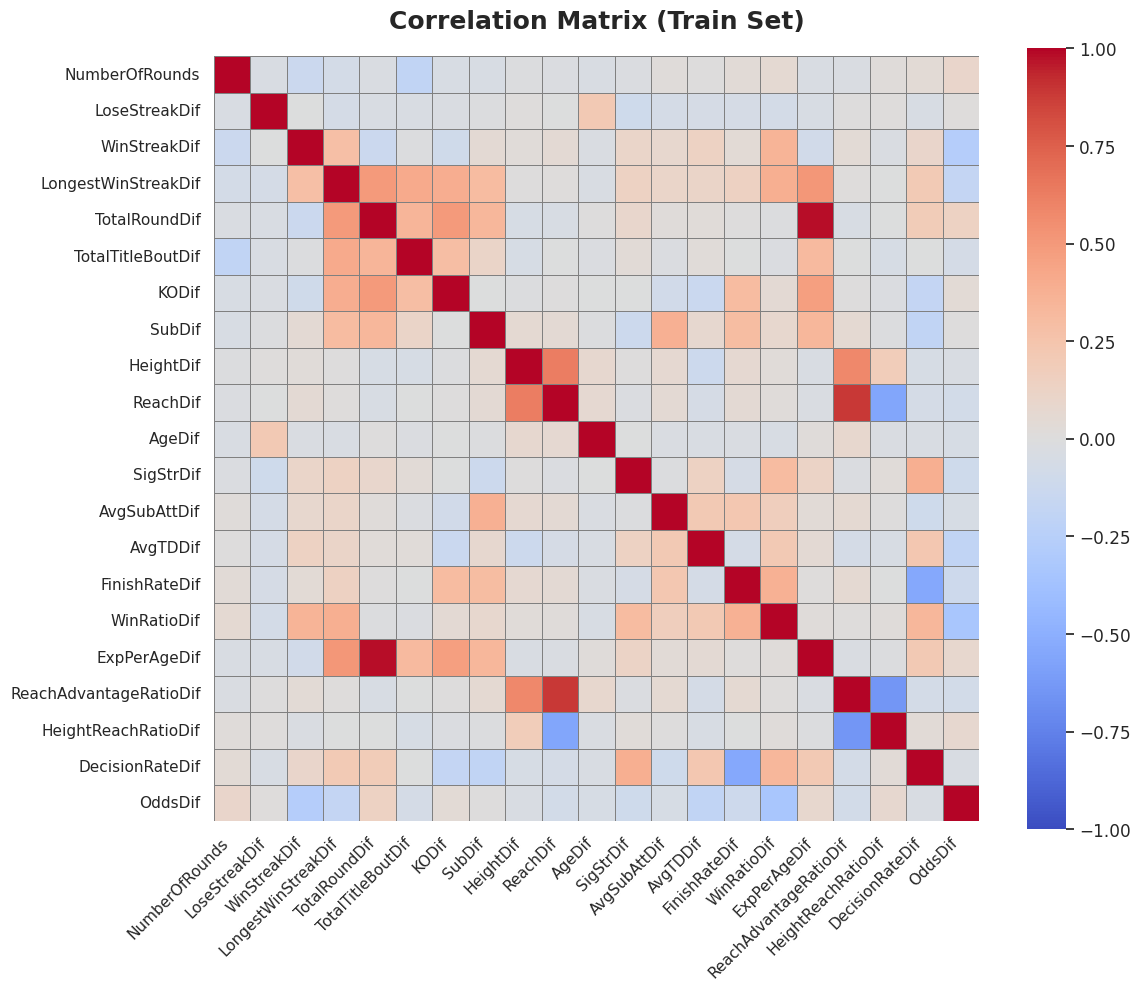

In [31]:
ufc_data.plot_corr(processed = status)

## 9. Redundant Column
- Number of Rounds: Equivalent to Titlebout
- TotalRoundDif: BlueTotalRoundsFought - RedTotalRoundsFought (better to use ExpPerAgeDif)

In [32]:
ufc_df = ufc_df.drop(['NumberOfRounds', 'TotalRoundDif'], axis=1)

In [33]:
# Preview the first few records
display(ufc_df.head())
display(ufc_df.columns)

,TitleBout,Gender,LoseStreakDif,WinStreakDif,LongestWinStreakDif,TotalTitleBoutDif,KODif,SubDif,HeightDif,ReachDif,...,FightStance,label,WeightGroup,FinishRateDif,WinRatioDif,ExpPerAgeDif,ReachAdvantageRatioDif,HeightReachRatioDif,DecisionRateDif,OddsDif
0,False,MALE,-1,5,-2,-4,4,-2,-2.54,10.16,...,Open Stance,1,Medium,0.283333,-0.035714,-0.477778,1.055556,-0.065058,-0.283333,-455.0
1,False,MALE,0,0,-2,0,-2,-1,5.08,0.00,...,Closed Stance,0,Light,0.293233,0.042614,-1.222222,1.000000,0.028571,-0.293233,-272.0
2,False,MALE,-1,4,0,0,1,1,-2.54,-7.62,...,Open Stance,0,Light,0.500000,0.095238,-0.077799,0.955882,0.028733,-0.500000,705.0
3,False,MALE,1,0,-1,0,2,-1,2.54,-2.54,...,Closed Stance,1,Heavy,-0.100000,-0.261905,0.453704,0.987013,0.025803,0.100000,610.0
4,False,MALE,0,3,-2,0,-5,0,0.00,-2.54,...,Closed Stance,1,Light,-0.607143,0.222222,-0.064516,0.985714,0.013872,0.607143,-410.0


Index(['TitleBout', 'Gender', 'LoseStreakDif', 'WinStreakDif',
       'LongestWinStreakDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
       'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif',
       'AvgTDDif', 'FightStance', 'label', 'WeightGroup', 'FinishRateDif',
       'WinRatioDif', 'ExpPerAgeDif', 'ReachAdvantageRatioDif',
       'HeightReachRatioDif', 'DecisionRateDif', 'OddsDif'],
      dtype='object')

## 10. Update UFCData Object

**After training, checking the importances feature plot, we decide to drop some columns that performs several worse than a Random Noise.**
- TotalTitleBoutDif
- ReachDif
- TitleBout
- Gender

In [34]:
ufc_df = ufc_df.drop(['TotalTitleBoutDif', 'ReachDif', 'TitleBout', 'LongestWinStreakDif', 'Gender'], axis=1)

In [35]:
ufc_data = UFCData(ufc_df)
ufc_data

📊 UFC Dataset Summary
----------------------------------------
🧪 Total samples      : 6001
🧪 Train/Test split  : 4800 / 1201
🧪 Total features     : 18

🔢 Numerical features : 16
🔠 Categorical features: 2
    - Binary          : 1
    - Multiclass      : 1

🏷 Label distribution (raw):
   - Class 0: 3484 (58.1%)
   - Class 1: 2517 (41.9%)

✅ No missing values detected

📈 Feature summary statistics (train set):
                           mean      std       min       max
LoseStreakDif             0.059    1.012    -6.000     6.000
WinStreakDif             -0.162    1.921   -18.000    10.000
KODif                    -0.536    2.181   -21.000    14.000
SubDif                   -0.334    1.877   -15.000    10.000
HeightDif                -0.066    6.843  -187.960    30.480
AgeDif                    0.196    5.213   -17.000    17.000
SigStrDif                -2.540   19.869  -118.000   128.222
AvgSubAttDif             -0.076    0.880    -8.400     7.800
AvgTDDif                 -0.159    1.76

## 11. Noise-based feature selection

In [36]:
# apply = False
# ufc_data.add_random_feature(apply=apply)
# ufc_data

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 12. Check Correlation Matrix

In [37]:
status = False
ufc_data.compute_corr(processed = status)
ufc_data.top_corr(processed = status)

,Feature 1,Feature 2,Correlation
114,ReachAdvantageRatioDif,HeightReachRatioDif,0.643900
61,HeightDif,ReachAdvantageRatioDif,0.581214
103,FinishRateDif,DecisionRateDif,0.544058


## 13. Inicialize Modeling Data: Standarize Numerical Data & Encode Categorical Data

In [38]:
ufc_data.standardize()
ufc_data.encode()

## 14. Check Modeling Correlation Matrix

In [39]:
status = True
ufc_data.compute_corr(processed = status)
ufc_data.top_corr(processed = status)

,Feature 1,Feature 2,Correlation
204,ReachAdvantageRatioDif,HeightReachRatioDif,0.643900
151,HeightDif,ReachAdvantageRatioDif,0.581214
39,WeightGroup_Light,WeightGroup_Medium,0.568048
193,FinishRateDif,DecisionRateDif,0.544058


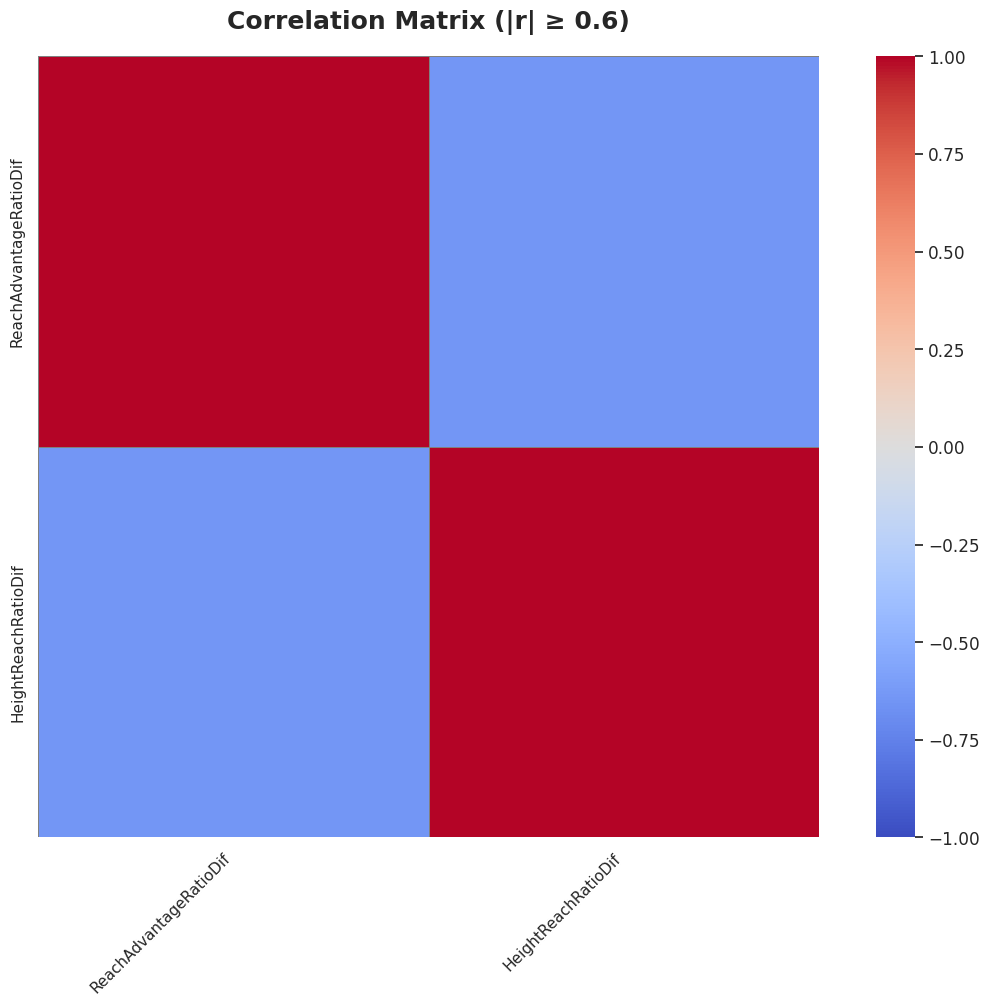

In [40]:
ufc_data.plot_corr(processed = status, threshold = 0.6)

## 15. Check Modeling Data

In [41]:
ufc_data._X_train_processed

,FightStance_Open Stance,WeightGroup_Heavy,WeightGroup_Light,WeightGroup_Medium,WeightGroup_Women,LoseStreakDif,WinStreakDif,KODif,SubDif,HeightDif,...,SigStrDif,AvgSubAttDif,AvgTDDif,FinishRateDif,WinRatioDif,ExpPerAgeDif,ReachAdvantageRatioDif,HeightReachRatioDif,DecisionRateDif,OddsDif
1535,0,0,1,0,0,-0.058245,0.605158,0.704641,0.177981,0.380838,...,0.147989,-0.367927,-2.175756,0.580189,-0.200670,0.526419,0.314804,-0.006030,-0.316891,0.472861
1760,0,0,1,0,0,0.929654,-0.956819,0.246027,0.177981,-0.361657,...,0.065941,1.564369,0.350706,0.161866,-0.252211,0.273520,-0.309274,-0.044893,0.115228,-0.883369
394,0,0,0,1,0,-0.058245,-1.477478,0.246027,2.842701,-0.361657,...,0.025169,0.768717,0.316718,0.336167,-0.664541,2.418547,-1.675147,1.709136,-0.064822,0.838586
4715,0,0,0,1,0,-0.058245,0.605158,-2.964271,0.177981,-0.732905,...,-0.694743,-0.212434,-0.118559,0.012465,0.995628,-1.902990,-0.288178,-0.428002,0.269556,0.390954
3123,1,0,1,0,0,-1.046144,0.084499,0.246027,0.177981,-1.104153,...,3.148019,0.086731,0.090129,0.161866,0.263201,0.506407,-0.300484,-0.840456,0.115228,0.457623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,0,0,1,0,0,0.929654,-0.436160,0.246027,0.177981,0.380838,...,0.199835,-0.595256,1.817867,0.161866,-2.520024,0.222281,2.083757,-2.142435,-2.045369,0.486195
3228,0,1,0,0,0,0.929654,1.125817,-0.671201,0.177981,1.865829,...,0.278862,0.370892,0.231747,0.580189,1.306910,-0.253890,1.827738,-0.304561,-0.316891,-0.837654
3238,0,0,0,0,1,0.929654,0.084499,-0.212587,-0.354963,-0.732905,...,-2.330222,-0.481592,-0.098676,-1.232542,-1.128412,-0.439898,0.007160,-0.870261,-0.604971,0.762394
1734,0,0,1,0,0,-0.058245,0.084499,0.246027,0.177981,-0.732905,...,0.127854,0.086731,0.090129,0.161866,0.263201,0.322062,-0.644322,-0.033107,0.115228,1.381460


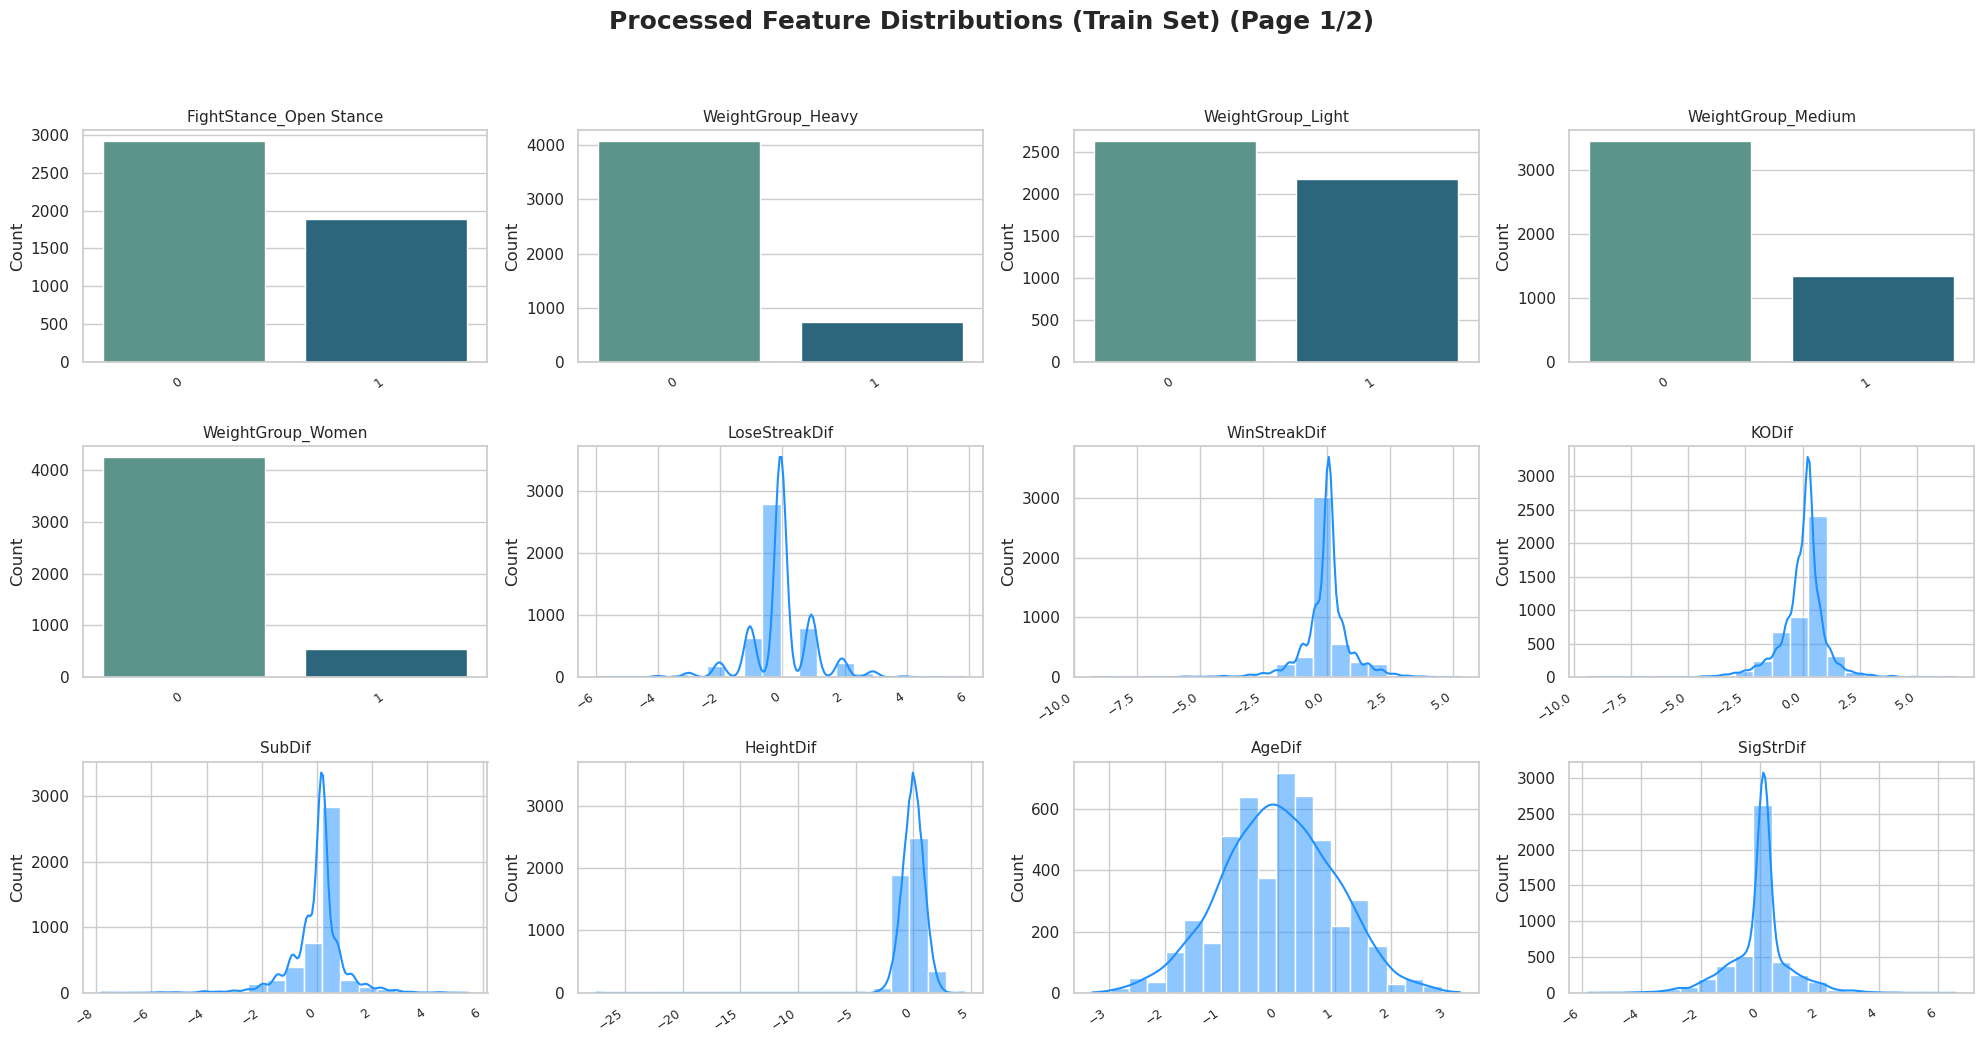

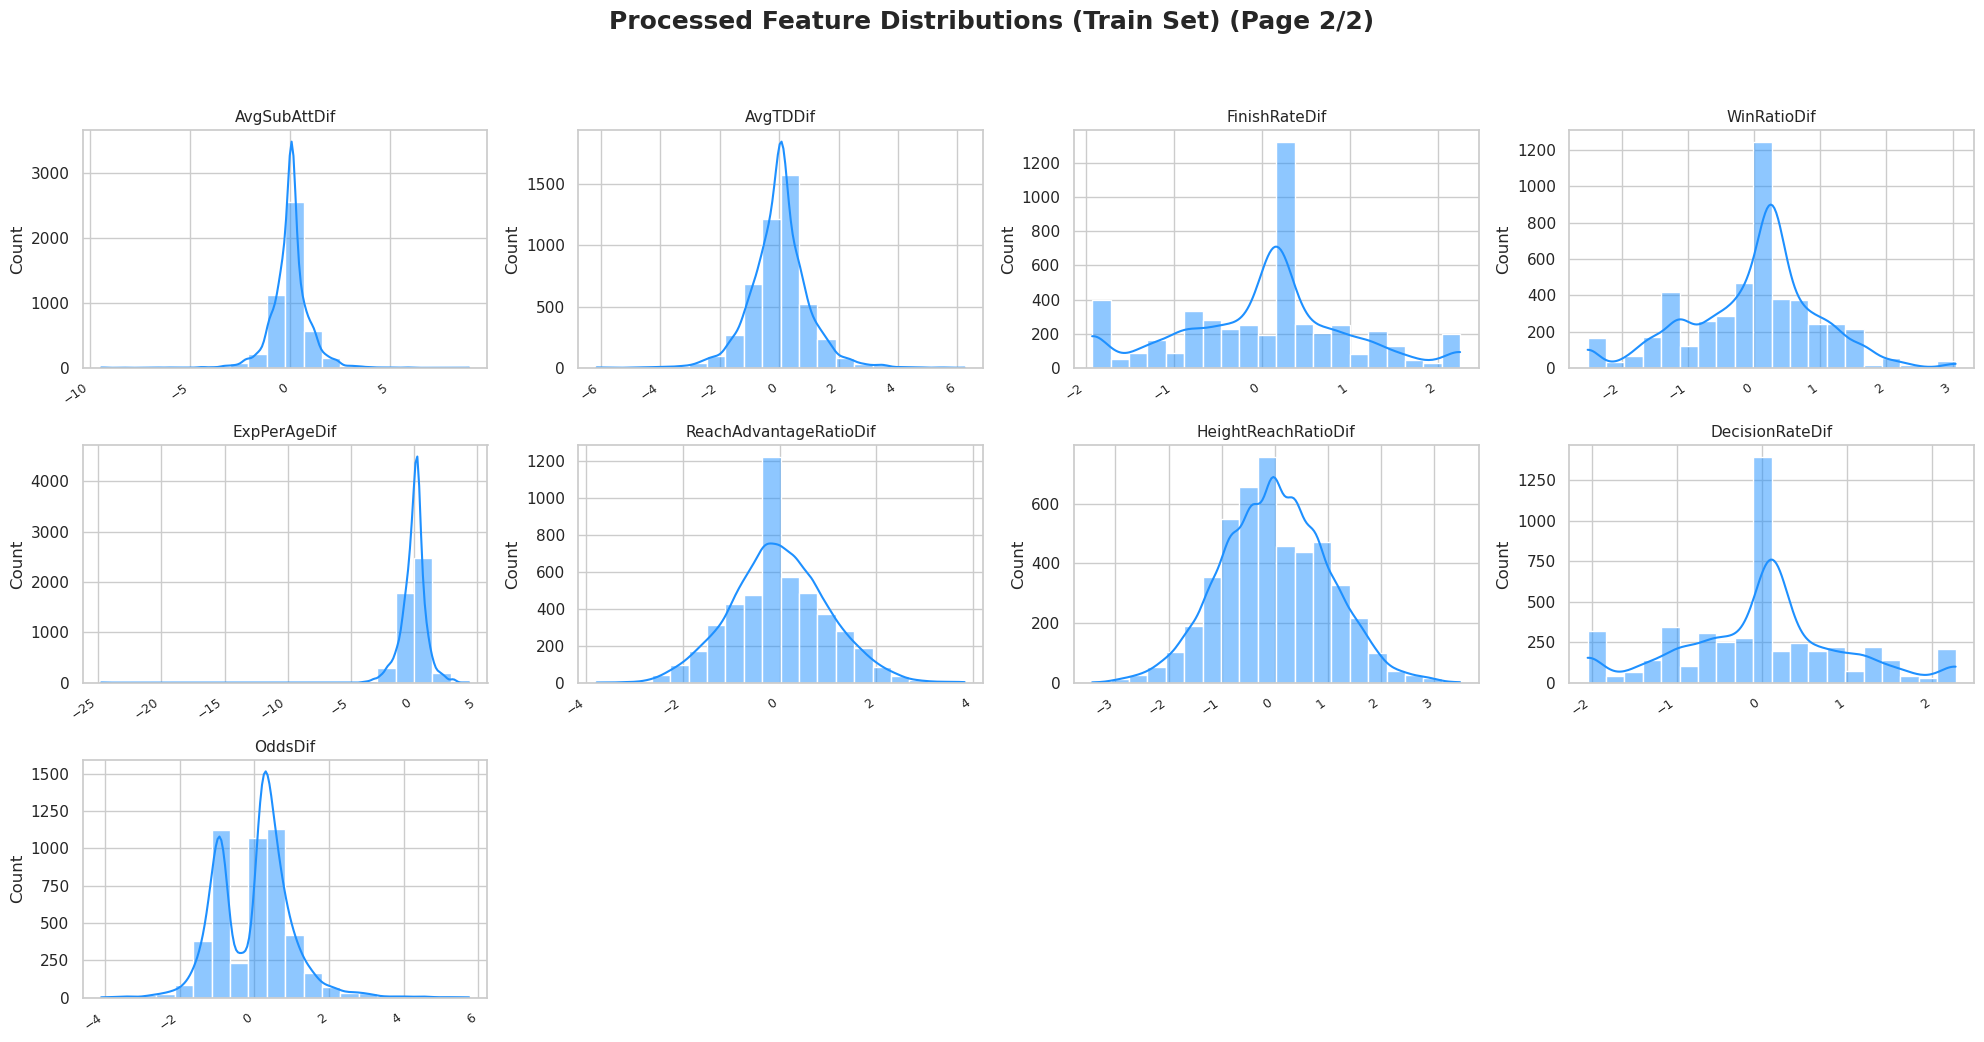

In [42]:
ufc_data.plot_feature_distributions(processed = True)

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 16. Save

In [43]:
ufc_modeling_data = ufc_data

In [44]:
save_data(ufc_modeling_data)

✅ UFCData object saved to: /home/mlioi/ufc-predictor/data/processed/ufc_data.pkl


In [45]:
save_ufc_datasets(ufc_modeling_data, project_root)

✅ UFCData object saved to: dict_keys(['ufc_train.csv', 'ufc_test.csv', 'ufc_processed_train.csv', 'ufc_processed_test.csv'])


<div style="text-align: center;">
     <img src="../img/ufc_logo.png" width="800" /> 
</div>